<a href="https://colab.research.google.com/github/DanteBM/Aprendizaje-Profundo/blob/main/tareas/tarea3/tarea3a_ap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entrena modelos de regresion para predecir edades en el conjunto de datos UTKFace. La solucion debe cumplir con los siguientes puntos:
1. Implementa la tuberıa de datos usando el [conjunto de rostros alineados y recortados](https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb)
2. Agrega acrecentamiento de datos usando un espejeo horizontal.
3. Particiona aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %.
4. Usando transferencia de conocimiento, entrena un modelo
    1. Reentrenando solo la ultima capa.
    2. Reentrenando toda la red.
5. Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

In [1]:
if "google.colab" in str(get_ipython()):
    !pip install torchinfo

In [2]:
# Sistema
from glob import glob
import os
from os.path import join

import re  # expresiones regulares

import random  # funciones aleatorias
from itertools import islice as take  # tomar n elementos de una secuencia

import numpy as np  # arreglos multidimensionales
import pandas as pd  # csv

# gráficas
import matplotlib.pyplot as plt

from tqdm import trange  # barras de progreso
from PIL import Image  # leer imágenes

# Utilidades
from torch.utils.data import DataLoader  # cargador de datos
from torchinfo import summary  # inspección de arquitectura

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as tvm
import torchvision.transforms as T

from sklearn.metrics import r2_score

# Creando dataset
En esta parte se crea la primera parte de la tubería de datos, junto con la partición aleatoria de 80% para entrenamiento y 20% para prueba.

In [3]:
class UTKFaceDataset:
    def __init__(self, subset, seed=0, transform = None, download=True): 
        if download:
            path = "data"
            self.download(path)
        
        data_dir = join("data", "UTKFace")
        if not os.path.exists(data_dir):
            raise RunTimeError("No existe data/UTKFace")
        
        files = glob(join(data_dir, "*.jpg"))
        random.Random(seed).shuffle(files)  # barajeo determinístico
        train_size = int(len(files)*0.8)
        
        if subset == "train":
            self.files = files[:train_size]
        elif subset == "test":
            self.files = files[train_size:]
        else:
            raise ValueError(f"{subset} no es un valor válido para subset"
                             "\nDebe ser 'train' o 'test'")
            
        self.transform = transform
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filepath = self.files[idx]
        
        # Extraer imagen
        img = Image.open(filepath)
        if self.transform is not None:
            img = self.transform(img)
            
        # Extraer edad
        filename = os.path.basename(filepath)
        edad, *_ = filename.split("_")
        y = int(edad)
        return img, y
        
    def download(self, root):
        URL = "https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download"
        filename = "UTKFace.tar.gz"
        filepath = join(root, filename)
        !mkdir -p {root}
        !wget -nc {URL} -O {filepath}
        !tar -zxf {filepath} -C {root}

--2021-06-17 03:20:29--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.189.27.18
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.189.27.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘data/UTKFace.tar.gz’

data/UTKFace.tar.gz 100%[===================>] 101.69M  12.7MB/s    in 9.0s    

2021-06-17 03:20:40 (11.3 MB/s) - ‘data/UTKFace.tar.gz’ saved [106634631/106634631]

Edad: 29


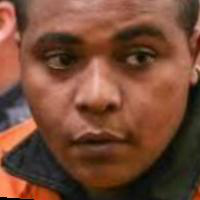

In [4]:
train_dataset = UTKFaceDataset("train")
ejemplo_img, ejemplo_y = train_dataset[27]
print("Edad:", ejemplo_y)
ejemplo_img

# Acrecentamiento de datos
La clase dataset ya está implementada, pero falta definir las transformaciones, y es aquí donde se incluye el espejo horizontal aleatorio.



In [5]:
# media y varianza de de ImageNet
IMG_SIZE = 244
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [6]:
# transformación de entrenamiento
train_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.RandomHorizontalFlip(),  # espejeo horizontal aleatorio
    T.ToTensor(),  # convertimos a torch.Tensor [C,H,W]
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# conjunto de datos
train_dataset = UTKFaceDataset("train", seed=27, transform=train_transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, num_workers=2)
len(train_dataset)

File ‘data/UTKFace.tar.gz’ already there; not retrieving.


18966

In [7]:
# Transformación de prueba
test_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)                         
])

test_dataset = UTKFaceDataset("test", seed=27, transform=test_transform)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, num_workers=2)
len(test_dataset)

File ‘data/UTKFace.tar.gz’ already there; not retrieving.


4742

# Entrenamiento

In [20]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    for X, y in dl:
        X = X.to(device)
        y_true = y.to(device)
        y_pred = model(X)  # predicción
        loss = F.mse_loss(y_pred, 
                          y_true.view(-1,1).float())  # computamos la pérdida
        opt.zero_grad()  # vaciamos los gradientes
        loss.backward()  # retropropagamos
        opt.step() # actualizamos parámetros


def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    with torch.no_grad():
        losses, r2s = [], []
        # si num_batches==None, se usan todos los lotes
        for X, y in take(dl, num_batches):
            X = X.to(device)
            y_true = y.to(device)
            y_pred = model(X) # predicción
            loss = F.mse_loss(y_pred, 
                              y_true.view(-1,1).float())  # computamos la pérdida
            
            r2 = r2_score(y_true.detach().cpu().numpy(), 
                          y_pred.detach().cpu().numpy())  # computamos r^2

            # guardamos históricos
            losses.append(loss.item())
            r2s.append(r2)

        loss = np.mean(losses)
        r2 = np.mean(r2s)
        
        return loss, r2

def save_check_point(model, epoch, run_dir, name):
    """Guarda un punto de control."""
    if not os.path.exists(run_dir):
        os.mkdir(run_dir)
    
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights_'+name+'.pth')
    )

def train(model, trn_dl, val_dl, epochs, only_last_layer,
          trn_batches=None, val_batches=None, run_dir="checkpoints", name="model"):
    opt = optim.Adam(model.parameters(), lr=1e-3)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # ciclo de entrenamiento
    best_r2 = 0
    losses, r2s = {"train":[], "val":[]}, {"train":[], "val":[]} 
    for epoch in trange(epochs):
        # Entrenar
        model.train()
        if only_last_layer:
            model.features.eval()
        
        train_epoch(trn_dl, model, opt, device)
        trn_loss, trn_r2 = eval_epoch(trn_dl, model, device, trn_batches)
        losses["train"].append(trn_loss)
        r2s["train"].append(trn_r2)

        # Evaluar            
        model.eval()
        val_loss, val_r2 = eval_epoch(val_dl, model, device, val_batches)
        losses["val"].append(val_loss)
        r2s["val"].append(val_r2)
        
        # si hay mejora guardamos punto de control
        if val_r2 > best_r2:
            best_r2 = val_r2
            save_check_point(model, epoch, run_dir, name)
            
    return losses, r2s


def plot_performance(losses, r2s):
    fig, ax = plt.subplots(ncols=2, figsize=(16,9))
    
    pd.DataFrame(losses).plot(ax=ax[0])
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    pd.DataFrame(r2s).plot(ax=ax[1])
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel(r"$r^2$")
    

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

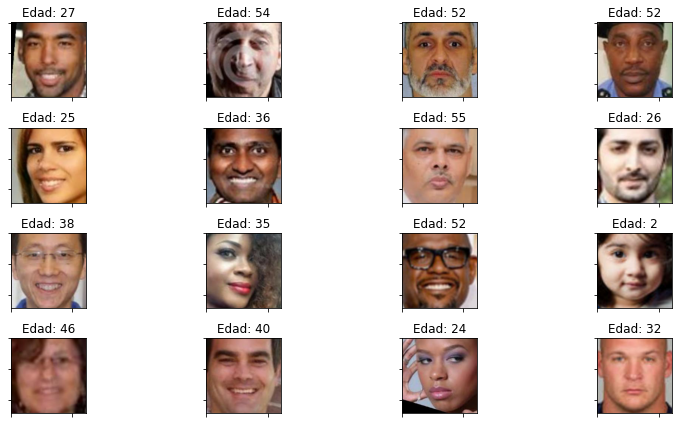

In [21]:
ejemplo_imgs, ejemplo_ys = next(iter(train_dataloader))
titulos = [f"Edad: {edad}" for edad in ejemplo_ys]
display_batch(ejemplo_imgs, titulos, 4, 4)

## Entrenando solamente la última capa

1280 es el número de características de entrada para la última capa. Este número se puede consultar al inspeccionar `modelo1.classifier` (antes de cambiarla, claro)

In [10]:
modelo1 = tvm.mobilenet_v2(pretrained=True)

# Congelando pesos
for parameter in modelo1.parameters():
    parameter.requires_grad = False

# Al sustituir "clasificador", por defecto requiere gradiente
modelo1.classifier = nn.Sequential(
    nn.BatchNorm1d(1280),
    nn.Linear(1280, 1)
)  # el clasificador ahora es regresor
modelo1

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [11]:
summary(modelo1, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV2                                   --                        --
├─Sequential: 1-1                             [1, 1280, 8, 8]           --
│    └─ConvBNActivation: 2-1                  [1, 32, 122, 122]         --
│    │    └─Conv2d: 3-1                       [1, 32, 122, 122]         (864)
│    │    └─BatchNorm2d: 3-2                  [1, 32, 122, 122]         (64)
│    │    └─ReLU6: 3-3                        [1, 32, 122, 122]         --
│    └─InvertedResidual: 2-2                  [1, 16, 122, 122]         --
│    │    └─Sequential: 3-4                   [1, 16, 122, 122]         (896)
│    └─InvertedResidual: 2-3                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-5                   [1, 24, 61, 61]           (5,136)
│    └─InvertedResidual: 2-4                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-6                   [1, 24, 61, 61]           (8,832)
│ 

In [12]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
modelo1 = modelo1.to(device)

cuda


100%|██████████| 20/20 [40:49<00:00, 122.49s/it]


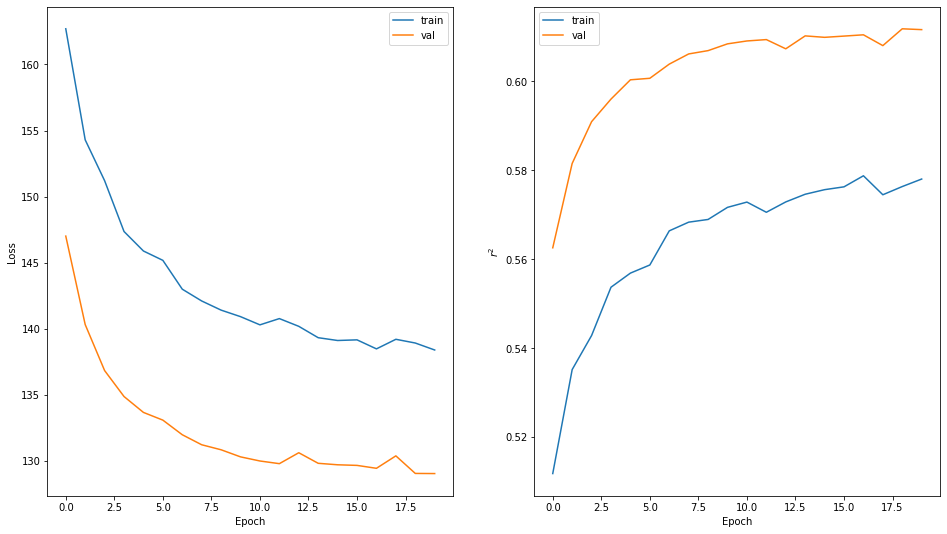

In [13]:
losses, r2s = train(modelo1, train_dataloader, test_dataloader, epochs=20, only_last_layer=True, name="model1")
plot_performance(losses, r2s)

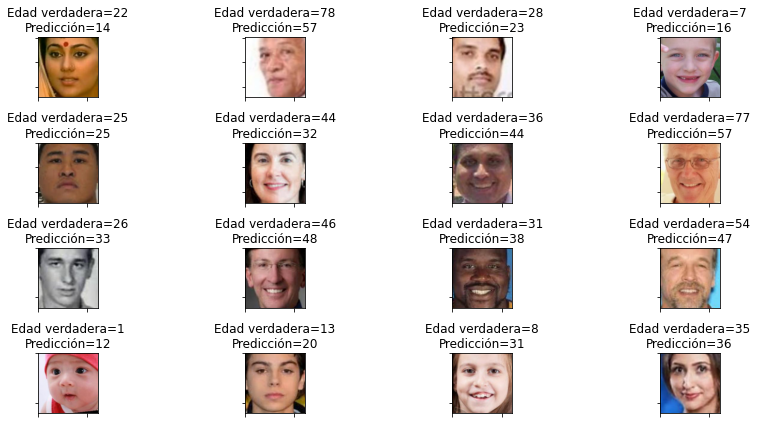

In [23]:
modelo1.to("cpu")
with torch.no_grad():
    batch = next(iter(test_dataloader))
    x, y_true = batch
    y_pred = modelo1(x).round()
    titles = [f'Edad verdadera={t}\nPredicción={int(p)}' for t, p in zip(y_true, y_pred.flatten())]
    display_batch(x, titles, 4, 4)

## Reentrenando todo el modelo

In [15]:
modelo2 = tvm.mobilenet_v2(pretrained=True)

for parameter in modelo2.parameters():
    parameter.requires_grad = True

modelo2.classifier = nn.Sequential(
    nn.BatchNorm1d(1280),
    nn.Linear(1280, 1)
)  # el clasificador ahora es regresor
modelo2

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [16]:
summary(modelo2, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV2                                   --                        --
├─Sequential: 1-1                             [1, 1280, 8, 8]           --
│    └─ConvBNActivation: 2-1                  [1, 32, 122, 122]         --
│    │    └─Conv2d: 3-1                       [1, 32, 122, 122]         864
│    │    └─BatchNorm2d: 3-2                  [1, 32, 122, 122]         64
│    │    └─ReLU6: 3-3                        [1, 32, 122, 122]         --
│    └─InvertedResidual: 2-2                  [1, 16, 122, 122]         --
│    │    └─Sequential: 3-4                   [1, 16, 122, 122]         896
│    └─InvertedResidual: 2-3                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-5                   [1, 24, 61, 61]           5,136
│    └─InvertedResidual: 2-4                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-6                   [1, 24, 61, 61]           8,832
│    └─Inver

In [17]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
modelo2 = modelo2.to(device)

cuda


100%|██████████| 20/20 [53:23<00:00, 160.15s/it]


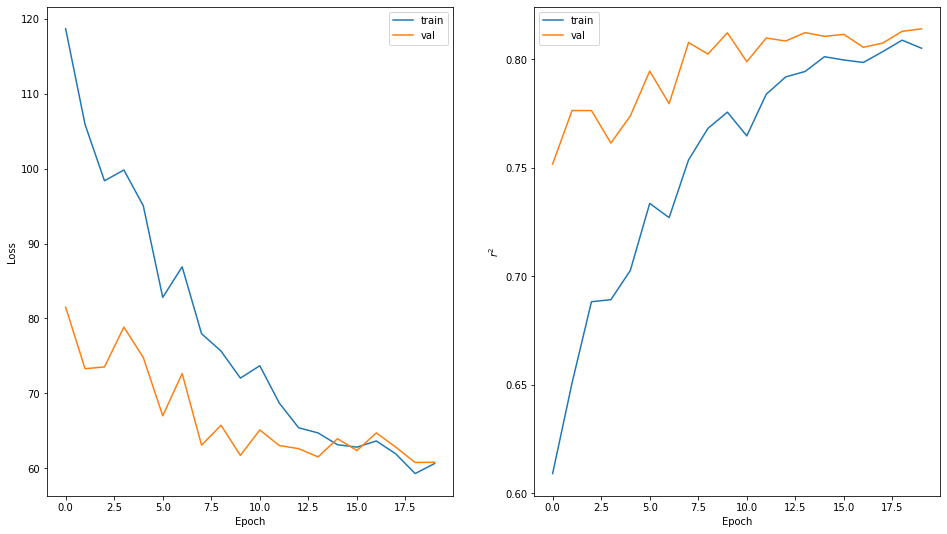

In [18]:
losses, r2s = train(modelo2, train_dataloader, test_dataloader, epochs=20, only_last_layer=False, name="model2")
plot_performance(losses, r2s)

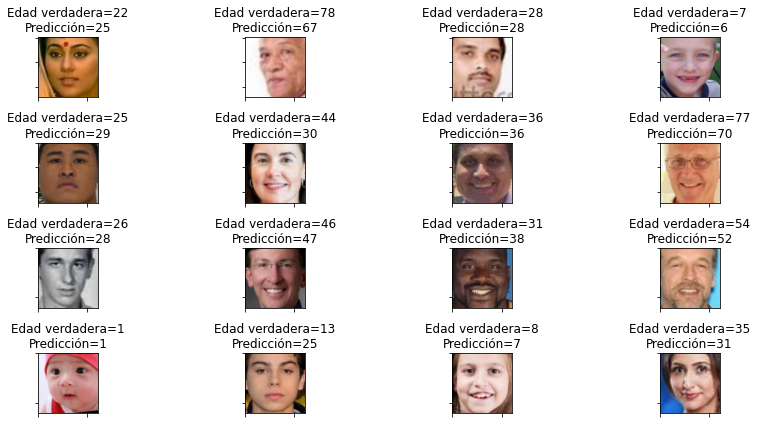

In [22]:
modelo2.to("cpu")
with torch.no_grad():
    batch = next(iter(test_dataloader))
    x, y_true = batch
    y_pred = modelo2(x).round()
    titles = [f'Edad verdadera={t}\nPredicción={int(p)}' for t, p in zip(y_true, y_pred.flatten())]
    display_batch(x, titles, 4, 4)

# Resultados

Se obtuvieron mejores resultados al re-entrenar todo el modelo (poco más de 0.8 de $R^2$), y no solamente la última capa (poco más de 0.6 de $R^2$). Una posible explicación es que el modelo tiene mayor flexibilidad al afinar los parámetros de toda la red.